In [3]:
#import matplotlib.pyplot as plt
import numpy as np
import pylab
import scipy
import plotly
from plotly import graph_objs as go
from plotly.offline import iplot, plot, init_notebook_mode
import networkx as nx
# importing librarys

In [4]:
def parseData(file):
    import csv
    Data =[]
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for lines in csv_reader:
           Data.append(lines)
        mainRootPoints =[]
        c=1
        while len(Data[c]) != 1:
            point = [float(Data[c][0]),float(Data[c][1])]
            mainRootPoints.append(point)
            c= c+1
        pqs =[]
        pq=[]
        c=c+1
        while c < len(Data):
            if len(Data[c]) ==1:
                pqs.append(pq)
                pq =[]
            if len(Data[c]) ==2:
                point = [float(Data[c][0]),float(Data[c][1])]
                pq.append(point)
            c = c+1
        pqs.append(pq)
    return (mainRootPoints, pqs)
#Making the data into readable segments

In [5]:
def readArborFile(fileName):
    Array = parseData(fileName)
    mainRootPoints = Array[0]
    lateralRoots =Array[1]
    Plant = nx.Graph()
    #adding the mainroot base to graph
    Plant.add_node(0)
    Plant._node[0]['label']= 'main root base'
    Plant._node[0]['coordinate'] = [mainRootPoints[0][0], mainRootPoints[0][1]]
    Plant._node[0]['root number']= 0
    #constructing the main root
    for i in range(1, len(mainRootPoints)):
        Plant.add_node(i)
        Plant._node[i]['label']= 'main root'
        Plant._node[i]['coordinate'] = (mainRootPoints[i][0], mainRootPoints[i][1])
        Plant._node[i]['root number']=0
        Plant.add_edge(i-1,i)
        Plant[i-1][i]['label'] = 'main root'
        Plant[i-1][i]['G'] = 0
        Plant[i-1][i]['root number']=0
    #this way we can have individual labels for points
    count = len(mainRootPoints)
    rootNumber =1
    #constructing the lateral roots
    for root in lateralRoots:
        # constructing a lateral root
        #making the first point
        Plant.add_node(count)
        Plant._node[count]['label'] = 'lateral root'
        Plant._node[count]['coordinate'] = (root[0][0],root[0][1])
        Plant._node[count]['root number'] = rootNumber
        #making the inside points and edges
        for i in range(1,len(root) -1):
            c =count +i
            Plant.add_node(c)
            Plant._node[c]['label'] = 'lateral root'
            Plant._node[c]['coordinate'] = (root[i][0],root[i][1])
            Plant._node[c]['root number'] = rootNumber
            Plant.add_edge(c-1,c)
            Plant[c-1][c]['label'] = 'lateral root'
            Plant[c-1][c]['G']=0
            Plant[c-1][c]['root number'] = rootNumber
        #making the root tip
        count = count +len(root)-1
        Plant.add_node(count)
        Plant._node[count]['label'] = 'lateral root tip'
        Plant._node[count]['coordinate'] = (root[-1][0],root[-1][1])
        Plant._node[count]['root number'] = rootNumber
        Plant.add_edge(count-1,count)
        Plant[count-1][count]['label'] = 'lateral root'
        Plant[count-1][count]['G'] =0
        Plant[count-1][count]['root number'] = rootNumber
        count = count+1
        rootNumber = rootNumber+1
    # return a networkX graph of the arbor
    return Plant

In [6]:
def optimalArbor(arbor, G, alpha):
    MainRootPoints = []
    pqs=[]
    Plant = nx.Graph()
    c=0
    for node in arbor.nodes():
        x, y = arbor.nodes[node]['coordinate']
        if 'main root base' == arbor.nodes[node]['label']:
            MainRootPoints.append([x,y])
            Plant.add_node(c)
            Plant._node[c]['label'] = arbor.nodes[node]['label']
            Plant._node[c]['coordinate'] = arbor.nodes[node]['coordinate']
            Plant._node[c]['root number'] =arbor.nodes[node]['root number']
            c = c+1
        elif 'main root' == arbor.nodes[node]['label']:
            MainRootPoints.append([x,y])
            Plant.add_node(c)
            Plant._node[c]['label'] = arbor.nodes[node]['label']
            Plant._node[c]['coordinate'] = arbor.nodes[node]['coordinate']
            Plant.add_edge(c-1,c)
            Plant[c-1][c]['label'] = 'main root'
            Plant[c-1][c]['G'] =0
            Plant[c-1][c]['root number'] =0
            c = c+1
        elif 'lateral root tip' == arbor.nodes[node]['label']:
            pqs.append([x,y])
            Plant.add_node(c)
            Plant._node[c]['label'] = arbor.nodes[node]['label']
            Plant._node[c]['coordinate'] = arbor.nodes[node]['coordinate']
            c = c+1
    rootNumber =1
    for pq in pqs:
        Array =findMostOptimal(MainRootPoints,G, alpha,pq) 
        txy =Array[0]
        xs=Array[1]
        ys=Array[2]
        Plant.add_node(c)
        Plant._node[c]['label']='optimal'
        Plant._node[c]['root number'] = rootNumber
        tx = txy[0][0]
        ty = txy[1][0]
        Plant._node[c]['coordinate'] = [tx,ty]
        Plant._node[c]['pq'] = pq
        for node in Plant.nodes():
            if 'lateral root tip' == Plant.nodes[node]['label']:
                if (pq[0],pq[1]) == Plant.nodes[node]['coordinate']:
                    Plant.add_edge(c, node)
                    Plant[c][node]['label'] ='lateral root'
                    Plant[c][node]['root number'] = rootNumber
                    Plant[c][node]['G'] = G
                    Plant[c][node]['xs'] = xs
                    Plant[c][node]['ys']= ys
                    break
        rootNumber = rootNumber +1
        c=c+1
    return Plant
    # arbor is a networkx graph
    # return a networkx graph representing optimal arbor

In [7]:
def findMostOptimal(MainRootPoints,G, al,pq):
    p = pq[0]
    q = pq[1]
    point1 = MainRootPoints[0]
    point2 = MainRootPoints[1]
    CD = 0
    bestDAC = findOptimalInSegment(point1, point2,G,al,pq,CD) 
    #return length, txy, xs,ys
    bestLength = bestDAC[0] 
    for i in range(2, len(MainRootPoints)):
        length = findOptimalInSegment(point1, point2,G,al,pq,CD)[0]
        if length < bestLength:
            bestDAC = findOptimalInSegment(point1, point2,G,al,pq,CD)
            #returns length, txy, xs, ys
            bestLength = length
        CD = CD +findOptimalInSegment(point1, point2,G,al,pq,CD)[4] 
        point1 = point2
        point2 = MainRootPoints[i]
    return (bestDAC[1:])
    #returen [txy,xs,ys]

In [8]:
def findOptimalInSegment(point1, point2,G,al,pq,CD):
    a =point1[0]
    b= point1[1]
    c= point2[0]
    d = point2[1]
    p=pq[0]
    q=pq[1]
    theta = findTheta (a,b,c,d) 
    ArrayDAC = deAngleCurve(G,al,p,q,theta,a,b,c,d,CD) 
    #return length, txy, xs,ys, cd
    return (ArrayDAC)
    #return length, txy, xs,ys,cd

In [9]:
def findTheta (a,b,c,d):
    theta = np.arctan((np.absolute(a-c))/(np.absolute(b-d)))
    m = (b-d)/(a-c)
    if m > 0:
        theta =-theta
    return theta

In [10]:
def deAngleCurve(G,al,p,q,theta,a,b,c,d,CD):
    pq = rotateLine([p],[q], theta, c,d) 
    #returns pq in this case
    pn = pq[0][0]
    qn = pq[1][0]
    tmax = rotateLine([c],[d], theta, a,b)
    tmax = tmax[1][0]
    best = findBest(tmax, G,pn,qn,al,CD)
    #returns best length and t
    t = best[1]
    XYPrime = XYDeAngle (tmax,G,pn,qn,t)
    #return x,y
    txy = reAngle([0],[best[1]], theta,c,d)
    XY = reAngle(XYPrime[0], XYPrime[1], theta,c,d)
    return(best[0], txy,XY[0],XY[1],CD)
    #return length, txy, xs,ys

In [11]:
def rotateLine(xs,ys,theta,a,b):
    nx=[]
    ny=[]
    R = [[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]]
    for i in range(0,len(xs)):
        A =[xs[i]-a,ys[i]-b]
        xy=np.array(np.matmul(A,R))
        nx.append(xy[0])
        ny.append(xy[1])
    return(nx, ny)

In [12]:
def findBest(Tmax,G,p,q,a,CD):
    t=0
    Tmax = -Tmax
    bestLength= 100000000000000000000.0
    bestT = t
    while t >= Tmax:
        b = (q - G * (p**2) - t)/p
        if p>0:
            x =np.linspace(0, p, num=50)
        elif p < 0:
            x =np.linspace(p, 0, num=50)
        lot = np.sqrt(1+(2*G*x + ((q-G*(p**2)-t)/p))**2)
        lot = scipy.integrate.trapezoid(lot,x)
        y= a*(lot) +(1-a)*(lot+CD+t)
        length = y
        if length < bestLength:
            bestLength = length
            bestT = t
        t = t - 0.001 #last 
    return(bestLength,bestT)

In [13]:
def XYDeAngle (tmax,G,p,q,t):
    x = np.linspace(0,p)
    if p <0:
        x = np.linspace(p,0)
    b=(q - G*(p**2) -t)/p
    y=G * x**2 + b*x + t
    return (x,y)

In [14]:
def reAngle(xs, ys, theta, a,b):
    nx =[]
    ny=[]
    R = [[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]]
    inR = np.linalg.inv(R)
    ab= [a,b]
    for i in range(0, len(xs)):
        Ap = [xs[i],ys[i]]
        App = np.matmul(Ap,inR)
        xy=np.array(np.add(App,ab))
        nx.append(xy[0])
        ny.append(xy[1])
    return(nx, ny)

In [15]:
def drawArbor(arbor):
    MainXs=[]
    MainYs=[]
    LateralXs=[]
    LateralYs=[]
    optX =[]
    optY=[]
    for node in arbor.nodes():
        x, y = arbor.nodes[node]['coordinate']
        if 'main root base' == arbor.nodes[node]['label']:
            baseX, baseY = x,y
        elif 'main root' == arbor.nodes[node]['label']:
            MainXs.append(x)
            MainYs.append(y)
        elif 'optimal' == arbor.nodes[node]['label']:
            optX.append(x)
            optY.append(y)
        else:
            LateralXs.append(x)
            LateralYs.append(y)
    node_mainBase =go.Scatter(x =[baseX], y = [baseY], mode='markers', name= 'main root base')
    node_main= go.Scatter(x = MainXs, y = MainYs, mode = 'markers', name = 'main root points')
    node_lateral = go.Scatter(x = LateralXs, y =LateralYs, mode = 'markers', name = 'lateral root points')
    node_opt = go.Scatter(x=optX, y= optY, mode= 'markers', name = 'optimal connections')
    MainXs=[]
    MainYs=[]
    LateralXs=[]
    LateralYs=[]
    for edge in arbor.edges():
        if 'main root' == arbor.edges[edge]['label']:
            x0, y0 = arbor.nodes[edge[0]]['coordinate']
            x1, y1 = arbor.nodes[edge[1]]['coordinate']
            MainXs.append(x0)
            MainXs.append(x1)
            MainXs.append(None)
            MainYs.append(y0)
            MainYs.append(y1)
            MainYs.append(None)
        elif 0 != arbor.edges[edge]['G']:
            xs = arbor.edges[edge]['xs']
            ys = arbor.edges[edge]['ys']
            for x in xs:
                LateralXs.append(x)
            LateralXs.append(None)
            for y in ys:
                LateralYs.append(y)
            LateralYs.append(None)
        else:
            x0, y0 = arbor.nodes[edge[0]]['coordinate']
            x1, y1 = arbor.nodes[edge[1]]['coordinate']
            LateralXs.append(x0)
            LateralXs.append(x1)
            LateralXs.append(None)
            LateralYs.append(y0)
            LateralYs.append(y1)
            LateralYs.append(None)
    edge_main = go.Scatter(x = MainXs, y =MainYs, mode = 'lines', name ='main root')
    edge_lateral = go.Scatter(x = LateralXs, y= LateralYs, mode='lines', name = 'lateral root')
    Array = [node_mainBase,node_main, node_opt, node_lateral,edge_main,edge_lateral]
    return Array
    # arbor is a networkx graph
    # draw the arbor in plotly

In [16]:
def FileDraw(file,G,alpha):
    Plant = readArborFile(file)
    fig=go.Figure()
    array = drawArbor(Plant)
    for x in array:
        fig.add_trace(x)
    print("original")
    fig.show()
    Plant2 = optimalArbor(Plant, G, alpha)
    fig2 = go.Figure(drawArbor(Plant2))
    array = drawArbor(Plant2)
    for x in array:
        fig.add_trace(x)
    print("optimal given: ", G, " ", alpha)
    fig2.show()
    print("optimal and original super imposed given: ",G, ", ", alpha )
    fig.show()


In [17]:
def supperImpose(file,G,alpha):
    Plant = readArborFile(file)
    fig=go.Figure()
    array = drawArbor(Plant)
    for x in array:
        fig.add_trace(x)
    Plant2 = optimalArbor(Plant, G, alpha)
    array = drawArbor(Plant2)
    for x in array:
        fig.add_trace(x)
    print("optimal and original super imposed given: G=",G, ", alpha=", alpha )
    fig.show()

optimal and original super imposed given: G= -0.5 , alpha= 0


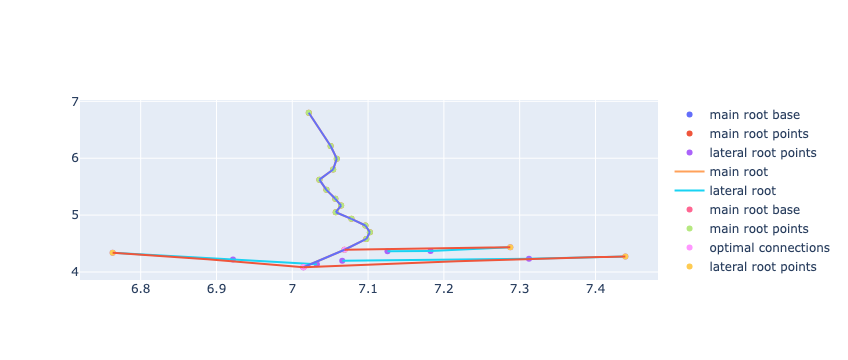

optimal and original super imposed given: G= 0.5 , alpha= 0.2


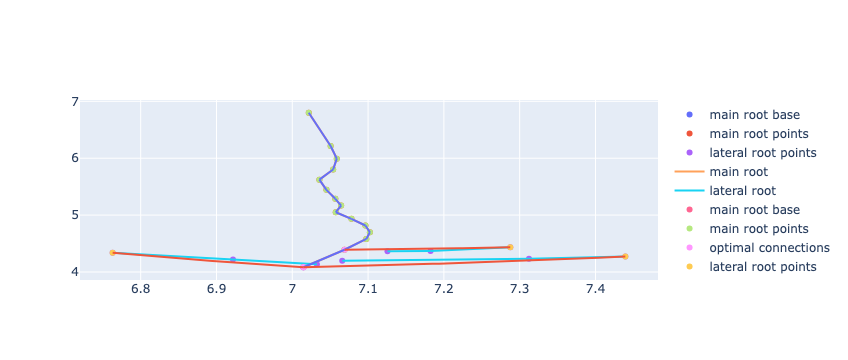